Project 4 Group 2 final presentation
=====
Table of contents
-----
1. Import data and libraries
2. Data adjustments
3. Basic k-means 
4. Mini batch
5. K++
6. Clustering Function and plotting
7. Results

## Import of Data and libraries
### Libraries

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scanpy as sc
from matplotlib import colors
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.ensemble import IsolationForest
from mpl_toolkits.mplot3d import Axes3D

### Data

In [28]:
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

## Data adjustments
### Filtering

In [29]:
sc.pp.filter_genes(data, min_cells=1)

filtered_data = np.array(data._X.todense())

**was das FIltering macht**
Conversion of data into a numpy array for easier handling.

### Removal of outliers and PCA

In [30]:
def remove_outliers():
    global pca_data
    X_train = pca_data
    clf = IsolationForest(behaviour="new", contamination=.07, max_samples=0.25)
    clf.fit(X_train)
    y_pred_train = clf.predict(X_train)
    pca_data = X_train[np.where(y_pred_train == 1, True, False)]

def pca(d, rmo=False):
    global dim, pca_data, pbmcs, genes

    dim = d
    pca = PCA(n_components=dim)
    pca_data = pca.fit_transform(filtered_data)
    if rmo == True:
        remove_outliers()
    print("Sum of explained variances: ""%.2f" % (sum(pca.explained_variance_ratio_)) + "\n")
    
    pbmcs = pca_data.shape[0]
    genes = pca_data.shape[1]

PCA to reduce dimensionality of our data to d dimension.
The variables **pbmcs** and **genes** describe the dimensionalty of our data.
Removal of outliers by Isolation forest can be chosen as a parameter (**rmo**).

## Basic k-means
### Initial centroid generation

In [31]:
def random_start_centroids(starttype):
    global centroids_array, genes, pbmcs, genes
    pbmcs = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randcell":
        centroids_numbers = np.random.randint(pbmcs, size=k)
        i = 0 
        while i < k:
            random_cell = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_cell, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)
    
    elif starttype == "k++":
        kppcentroids()

Creating an empty array of centroids (**centroids_array**) which can be extended by three differnet methods.
**"randcell"** selects k random samples from the given data.
**"randum"** creates k new centroids by creating random numbers inbetween the maximum and minimum of the data values.
**"k++"** performs the k++ centroid function.
### Assignment of datapoints to closest centroids

In [32]:
def dist(cell_point, cluster_number):

    return np.linalg.norm(pca_data[cell_point, :] - centroids_array[cluster_number - 1, :])


def assign_centroids(data_array):
    global nearest_centroid
    i = 0
    array_dim1 = data_array.shape[0]
    nearest_centroid = np.zeros([array_dim1, 1])
    
    # loop over all datapoints
    while i < array_dim1:
        sml_distance = -1 # hab hier jetzt mal -1 gemacht mal schauen ob das problemlos geht

        # loop over every centroid
        j = 1
        while j <= k:

            if sml_distance == -1 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

**dist** function returns linear distance between a selected datapoint(i) and a selected centroid(j).
Creation of nearest_centroid array consisting of datapoints and their associated closest centroid.
### Empty check

In [33]:
def empty_check():
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids(pca_data)
            empty_check()
        i += 1

Ensuring, if **"randnum"** method is chosen, no empty clusters were generated.
### Generation of new centroids

In [34]:
def new_centroids():
    global centroids_array, centroids_oldarray, nearest_centroid_squeeze
    centroids_oldarray = centroids_array # create copy of old array for threshold funcion
    nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
    centroids_array = np.empty([0, genes])

    i = 1
    while i <= k:
        calc_means = np.mean(pca_data[nearest_centroid_squeeze == i], axis = 0)
        centroids_array = np.append(centroids_array, np.expand_dims(calc_means, axis = 0), axis = 0)
        i += 1

Centroids of last generation are saved as **centroids_oldarray** to calculate distance to the subsequent generation for the threshold function.
Creation of second centroid generation by calculation of the mean of associated data points.
### Threshholding

In [35]:
def improv():
    distances = []
    i = 0
    while i < k: 
        d = np.linalg.norm(centroids_array[i, :] - centroids_oldarray[i,:])
        distances.append(d)
        i += 1
    c_str = np.array2string(np.array(distances), precision=2)
    print("Distances of clusters as compared to last generation: \n" + str(c_str))

Calculation of distance inbetween each cluster after n iterations
### Runtime function

In [36]:
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("\truntime: " + elapsed)

**Glaube kaum dass das eines comments bedarf oder**
### Complete basic k-means

In [37]:
def kmeans(start, k1, n_iterations, t):
    global k
    k = k1
    i = 0
    runtime_start()

    random_start_centroids(start)
    assign_centroids(pca_data)

    if start == "randnum":
        empty_check()

    if t == None:

        while i < n_iterations:
            new_centroids()
            assign_centroids(pca_data)
            i += 1
        improv()

    else:
        count = 0
        d = t

        while d >= t:
            new_centroids()
            assign_centroids(pca_data)
            d = np.linalg.norm(centroids_oldarray-centroids_array)
            count+=1
        print("%s iterations were performed" %count)
        
    print("\nKMEANS:")
    print("\ngroup 4_2 algorithm:")
    print(runtime_end())
    print("\twss: " + str(wss('self')))


Function performing a basic k-means with **k(k1)** clusters until change of clusters is below the threshold **t**. If no threshold is chosen **n** iterations are performed.

## Mini Batch

In [38]:
def minibatch(k1, n_iterations, b):
    global k, pca_data, nearest_centroid_squeeze, pca_data, bg, n_iterationsg, centroids_array, cnnew
    k = k1
    bg = b
    n_iterationsg = n_iterations
    runtime_start()
    v = np.zeros((k, 1))
    j = 1
    random_start_centroids("randcell")
    cnnew = centroids_array
    while (j <= n_iterations):
        # Reduce data to batch
        pca_batch = pca_data[np.random.randint(pca_data.shape[0], size=b), :]
        # Start centroids
        assign_centroids(pca_batch)
        i = 0
        while (i < b):
            c = cnnew[int(nearest_centroid[i, 0])-1, :]
            v[int((nearest_centroid[i, 0]-1)), 0] =  int(v[int((nearest_centroid[i, 0]-1)), 0]) + 1
            n = 1/v[int((nearest_centroid[i, 0]-1)), 0]
            cnnew[int(nearest_centroid[i, 0])-1, :] = c * (1-n) + pca_data[i, :] * n
            i+=1
        j+=1

    centroids_array = cnnew
    assign_centroids(pca_data)
    nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
    print("\nMINI-BATCH:")
    print("\ngroup 4_2 algorithm:")
    print(runtime_end())
    print("\twss: " + str(wss('self')))

**Tristan das darfst du commenten**
## K++

In [39]:
def kppcentroids():
    global centroids_array, dist_array, prob_array
    first_centroid = np.random.randint(pbmcs, size=1)
    i = 0
    centroids_array = np.append(centroids_array, pca_data[first_centroid, :], axis=0)
    dist_array = np.empty ([0,pbmcs])
    prob_array = np.empty ([0,pbmcs])
    j = 0
     
    while i < k - 1:
        z = centroids_array.shape[0] + 1 
        while j < pbmcs:
            sml_distance = -1
            l = 1 
            while l < z:
                if sml_distance == -1 or dist(j, l) < sml_distance:
                    sml_distance = dist(j, l)
                l += 1
            dist_array = np.append(dist_array,sml_distance **2)        
            j += 1
        prob_array = dist_array / np.sum(dist_array)
        s = np.random.choice(pbmcs,p = prob_array )
        centroids_array = np.append(centroids_array, np.expand_dims(pca_data[s, :], axis=0), axis=0)
        i += 1

Creation of emtpy centroids array similar to random method.
First centroid is chosen randomly. 
For every conecutive centroid an array of the squared distances between each data point to its closest centroids is created (**dist_array**).
According probability array is created with identical dimension (**prob_array**).
Centroid array is appeneded by selecting a random datapoint with according probabilty until k centroids are generated.
Afterwards clustering follows basic k-means algorythm.
## Clustering Function and plotting
### Sklearn k-means

In [40]:
def sklearn_kmeans_function(var, k, start):
    global y_sklearnkmeans, sklearn_kmeans, pca_data
    runtime_start()
    if start == "randcell" or start == "randnum": 
        if var == "kmeans":
            sklearn_kmeans = KMeans(init='random', n_clusters=k).fit(pca_data)
        if var == "mini":
            sklearn_kmeans = MiniBatchKMeans(n_clusters=k, init = 'random', max_iter=n_iterationsg, batch_size=bg).fit(pca_data)
    if start == "k++": 
        if var == "kmeans":
            sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
        if var == "mini":
            sklearn_kmeans = MiniBatchKMeans(n_clusters=k, max_iter=n_iterationsg, batch_size=bg).fit(pca_data)
    y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
    print("\nsklearn kmeans:")
    print(runtime_end())
    print("\twss: " + str(wss('sklearn')))

### Plotting

In [41]:
def plots(add = ""):
    global fig1, fig2
    # 2D plots:
    additional = ""
    if add == "mini":
        additional = " (mini-batch)"
    # Kmeans
    fig1 = plt.figure(1, figsize=[10, 5], dpi=200)
    plt1, plt2 = fig1.subplots(1, 2)
    plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=0.5, cmap='gist_rainbow')
    # plt1.plot(centroids_array[:, 0], centroids_array[:, 1], markersize=5, marker="s", linestyle='None', c='k')
    plt1.set_title('kmeans' + additional)
    
    # Sklearnkmeans
    plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=0.5, cmap='gist_rainbow')
    # plt2.plot(sklearn_kmeans.cluster_centers_[:, 0], sklearn_kmeans.cluster_centers_[:, 1], markersize=5, marker="s", linestyle='None', c='k')
    plt2.set_title('sklearn kmeans' + additional)
    
    # 3D plots
    if dim >= 3:
        fig2 = plt.figure(2, figsize=[15,10], dpi=200)

        # Kmeans
        plt21 = fig2.add_subplot(221, projection = '3d')
        plt21.scatter(pca_data[:, 1], pca_data[:, 2], pca_data[:, 0], s=2, c = nearest_centroid_squeeze, cmap='gist_rainbow')
        # plt21.plot(centroids_array[:, 0], centroids_array[:, 1], centroids_array[:, 2], markersize=5, marker="s", linestyle='None', c='k')
        plt21.set_title('3d kmeans' + additional)

        # Sklearnkmeans
        plt22 = fig2.add_subplot(222, projection = '3d')
        plt22.scatter(pca_data[:, 1], pca_data[:, 2], pca_data[:, 0], s=2, c = y_sklearnkmeans, cmap='gist_rainbow')
        # plt22.plot(sklearn_kmeans.cluster_centers_[:, 0], sklearn_kmeans.cluster_centers_[:, 1], sklearn_kmeans.cluster_centers_[:, 2], markersize=5, marker="s", linestyle='None', c='k')
        plt22.set_title('3D kmeans by sklearn' + additional)


**3D plots drinnen lassen ??**
<br>
<br>
### Quality control

In [42]:
def highlightdiffs(start, k, max_iterations, threshold, batch_size):
    global nearest_centroid_squeeze, centroids_array

    # Performing KMeans clustering and saving results
    kmeans(start, k, max_iterations, threshold)
    centroids_array = centroids_array[centroids_array[:,0].argsort()]
    assign_centroids(pca_data)
    vr = np.squeeze(nearest_centroid.astype(int))

    # Performing Mini-Batch KMeans clustering and saving results
    minibatch(k, max_iterations, batch_size)
    centroids_array = centroids_array[centroids_array[:,0].argsort()]
    assign_centroids(pca_data)
    vm = np.squeeze(nearest_centroid.astype(int))

    # Compare results of both algorithms and find differences
    vn = np.where(np.subtract(vr, vm) == 0)[0]
    nearest_centroid_squeeze = np.squeeze(np.zeros(np.size(nearest_centroid)).astype(int))
    np.put(nearest_centroid_squeeze, vn, 1)

    # Plot
    fig3 = plt.figure(3, figsize=[5, 5], dpi=200)
    plt3 = fig3.subplots(1)
    plt3.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=0.5, cmap=colors.ListedColormap(['red', 'white']))
    plt3.set_title('differences')
    
def wss(where):
        i = 0
        wsssum = 0
        while (i < len(pca_data)):
            if where == "self":
                assigned_centroid = int(nearest_centroid[i,0])
                centr_val = centroids_array[assigned_centroid-1]
            if where == "sklearn":
                assigned_centroid = int(y_sklearnkmeans[i])
                centr_val = sklearn_kmeans.cluster_centers_[assigned_centroid]
            point_val = pca_data[i] 
            i+=1
            sqdist = np.linalg.norm(centr_val - point_val)**2
            wsssum += np.trunc(sqdist)              
        return(wsssum)


**Once again dir überlassen t-boy, falls wir das überhaupt drinnen behalten wollen. ist halt hässlich ohne sonst weil es in der cluster() fnct steht** :D


###  Final Clustering Function

In [43]:
def cluster(pcas = 5, rmo=True, variant = 'kmeans', start='randcell', k = 3, max_iterations = 10, threshold = 0.00001, batch_size = 2000, hd = False):
    pca(pcas, rmo)
    if hd == True:
        highlightdiffs(start, k , max_iterations, threshold, batch_size)
    else:
        if variant == "kmeans":
            kmeans(start, k, max_iterations, threshold)
            sklearn_kmeans_function("kmeans", k, start)
            plots()

        if variant == "mini":
            minibatch(k, max_iterations, batch_size)
            sklearn_kmeans_function("mini", k, start)
            plots("mini")


The depicted cluster funtion allows us to perform kmeans clustering while giving us the ability to select following parameters:
1. Amount of principal components
2. Removal of outliers (Y/N)
3. Performance of k-means or mini batch k-means algorythm
4. Method for creating the initial cluster Generation (random cells, random numbers, k++)
5. Cluster-amount
6. Maximum iterations (not utilizied if a threshold is defined)
7. Minimum threshhold for change of cluster centers 
8. Batch size for mini batch k-means
9. Adding a function that highlights differences in created plots (Y/N)

By combining these features we are able to utilize the same function for all three subprojects.
## Results
### Basic k-means

Sum of explained variances: 0.60

17 iterations were performed

KMEANS:

group 4_2 algorithm:
	runtime: 0:00:02.522027
	wss: 7575359.0

sklearn kmeans:
	runtime: 0:00:00.119106
	wss: 7575383.0


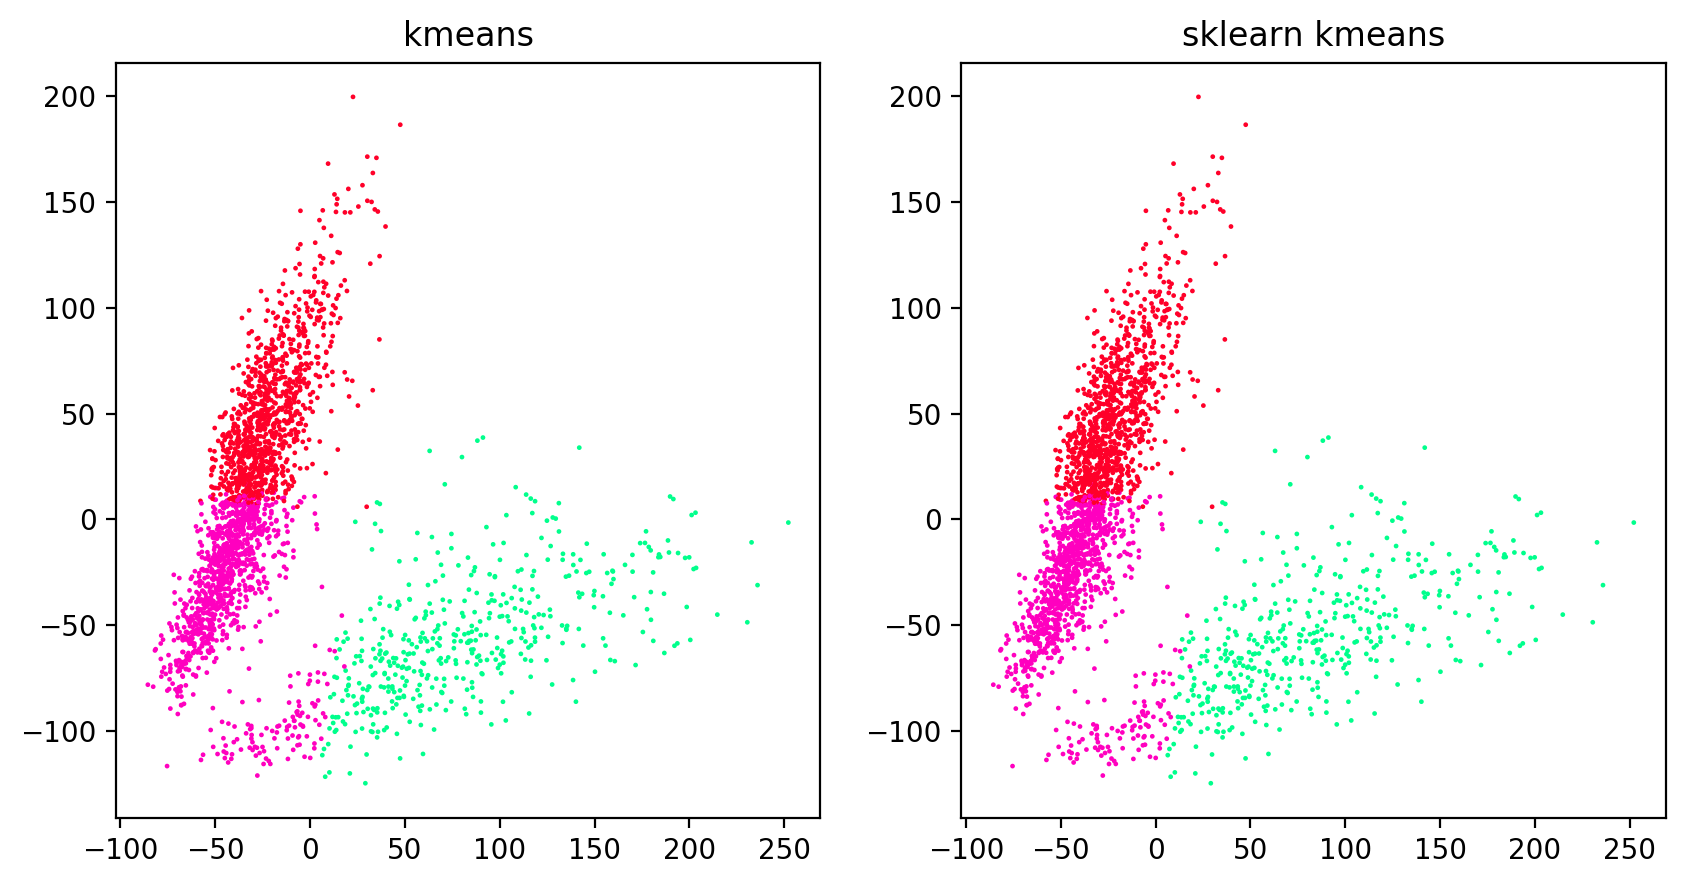

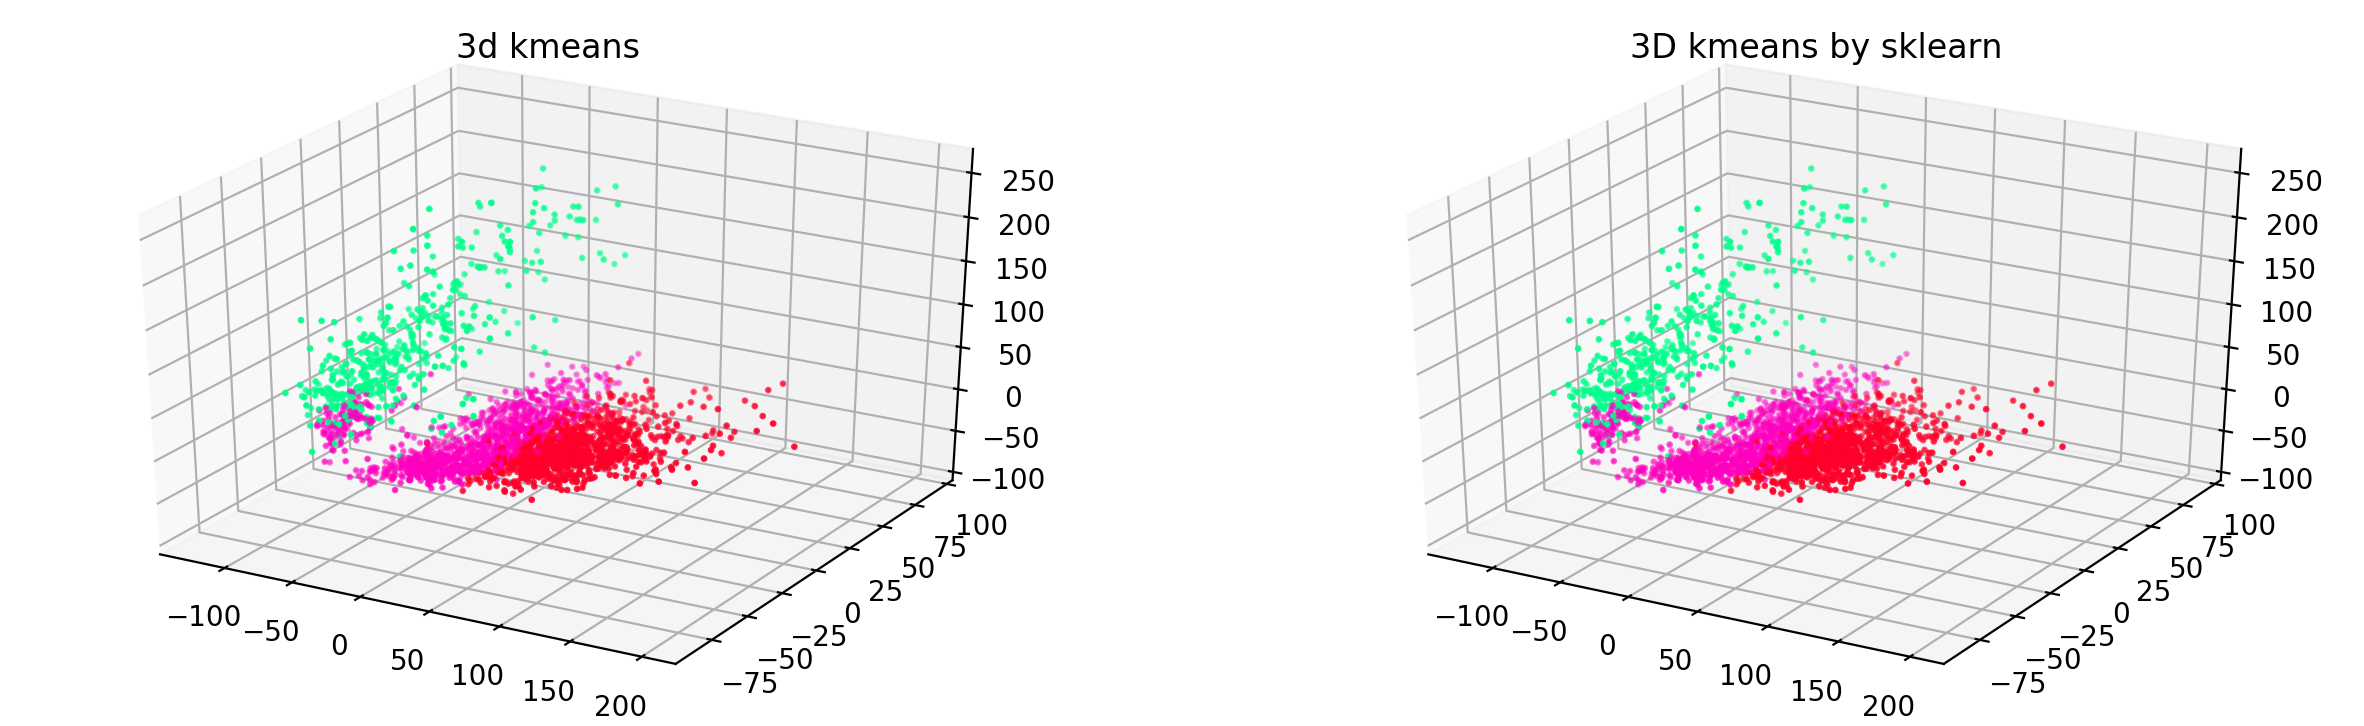

In [44]:
cluster(variant = 'kmeans', start = "randcell", hd=False, k=3)

### Mini batch k-means

In [ ]:
cluster(variant = 'mini', start = "randcell", hd=False, k=3)

### K++

In [ ]:
cluster(variant = 'kmeans', start = "k++", hd=False, k=3)